In [10]:
import urllib.request as libreq
import time
import xml.etree.ElementTree as ET
from datetime import datetime
import pandas as pd



In [ ]:

FREQUENCY_LIMIT = 10      

start_time = time.time()
end_time = start_time + 10
batch_size = 10000
i = 0

filename = f'extractions/XML/arxiv_data_{datetime.now().strftime("%Y%m%d_%H%M%S")}.xml'

with open(filename, 'ab') as f:
    while time.time() < end_time:
        start = str(i * batch_size)
        max_results = str(batch_size) 

        # Construction de l'URL avec des paramètres distincts pour start et max_results
        url = f'http://export.arxiv.org/api/query?search_query=all&start={start}&max_results={max_results}'
        
        try:
            with libreq.urlopen(url) as response:
                r = response.read()
                # Écriture du contenu XML dans le fichier unique
                f.write(r)
        except libreq.HTTPError as e:
            error_data = e.read()
            try:
                # Parsing du XML de l'erreur pour extraire le contenu du tag <summary>
                root = ET.fromstring(error_data)
                summary = root.find('.//{http://www.w3.org/2005/Atom}summary')
                if summary is not None:
                    print(f"HTTP Error {e.code}: {summary.text}")
                else:
                    print(f"HTTP Error {e.code}: Erreur inconnue, impossible de trouver le résumé")
            except Exception as parse_error:
                print(f"HTTP Error {e.code}: Erreur lors du parsing du XML d'erreur - {parse_error}")
        except Exception as ex:
            print(f"Une autre erreur s'est produite: {ex}")
            
        
        time.sleep(FREQUENCY_LIMIT)
        i += 1


KeyboardInterrupt: 

In [ ]:
filename = f'extractions/XML/tests.xml'

with open(filename, 'ab') as f:    
    start = str(0 * 1000)
    max_results = str(1000) 

    # Construction de l'URL avec des paramètres distincts pour start et max_results
    url = f'http://export.arxiv.org/api/query?search_query=cat:math'

    try:
        with libreq.urlopen(url) as response:
            r = response.read()
            # Écriture du contenu XML dans le fichier unique
            f.write(r)
    except libreq.HTTPError as e:
        error_data = e.read()
        try:
            # Parsing du XML de l'erreur pour extraire le contenu du tag <summary>
            root = ET.fromstring(error_data)
            summary = root.find('.//{http://www.w3.org/2005/Atom}summary')
            if summary is not None:
                print(f"HTTP Error {e.code}: {summary.text}")
            else:
                print(f"HTTP Error {e.code}: Erreur inconnue, impossible de trouver le résumé")
        except Exception as parse_error:
            print(f"HTTP Error {e.code}: Erreur lors du parsing du XML d'erreur - {parse_error}")
    except Exception as ex:
        print(f"Une autre erreur s'est produite: {ex}")

In [ ]:

XML_file = f'extractions/XML/arxiv_data_20250304_183712.XML'
CSV_file = f'extractions/CSV/arxiv_data_{time.time()}.csv'

# Define the namespace dictionary for XML parsing
namespaces = {
    'atom': 'http://www.w3.org/2005/Atom',
    'arxiv': 'http://arxiv.org/schemas/atom'
}

# Function to parse a single entry
def parse_entry(entry):
    # Extract basic information
    article = {
        'id': entry.find('atom:id', namespaces).text,
        'title': entry.find('atom:title', namespaces).text.strip(),
        'published': entry.find('atom:published', namespaces).text,
        'updated': entry.find('atom:updated', namespaces).text,
        'summary': entry.find('atom:summary', namespaces).text.strip(),
    }
    
    # Extract authors
    authors = [author.find('atom:name', namespaces).text 
              for author in entry.findall('atom:author', namespaces)]
    article['authors'] = '; '.join(authors)
    
    # Extract DOI if available
    doi = entry.find('arxiv:doi', namespaces)
    article['doi'] = doi.text if doi is not None else None
    
    # Extract categories
    primary_category = entry.find('arxiv:primary_category', namespaces)
    article['primary_category'] = primary_category.get('term') if primary_category is not None else None
    
    return article

# Parse the XML file and create a list of articles
articles = []

# Read and process the XML content
with open(XML_file, 'r', encoding='utf-8', errors='replace') as file:
    content = file.read()

# Split the content properly at the XML document boundaries
xml_docs = content.split('<?xml version="1.0" encoding="UTF-8"?>')
for doc in xml_docs:
    if not doc.strip():  # Skip empty strings
        continue
    
    # Reconstruct proper XML document
    doc = '<?xml version="1.0" encoding="UTF-8"?>' + doc
    try:
        root = ET.fromstring(doc)
        # Process each entry
        entries = root.findall('.//atom:entry', namespaces)
        for entry in entries:
            article_data = parse_entry(entry)
            articles.append(article_data)
    except ET.ParseError as e:
        print(f"Skipping malformed XML document: {str(e)}")
        continue

# Create DataFrame and save to CSV
df = pd.DataFrame(articles)
df.to_csv(CSV_file, index=False)
print(f"Processed {len(articles)} articles")

Processed 20900 articles


In [6]:
len(df.id.unique())

20900

In [7]:
df.head()

,id,title,published,updated,summary,authors,doi,primary_category
0,http://arxiv.org/abs/2401.04381v1,Spaces where all bijections are morphisms,2024-01-09T07:01:04Z,2024-01-09T07:01:04Z,Here we classify all topological spaces where ...,Lucas H. R. de Souza,None,math.GN
1,http://arxiv.org/abs/1911.11405v1,A Note on Computational Complexity of Kill-all Go,2019-11-26T08:49:54Z,2019-11-26T08:49:54Z,Kill-all Go is a variant of Go in which Black ...,Zhujun Zhang,None,cs.CC
2,http://arxiv.org/abs/2501.13404v1,Classification of Homogeneous Local Representa...,2025-01-23T06:06:47Z,2025-01-23T06:06:47Z,"For a natural number $n$, denote by $B_n$ the ...",Taher I. Mayassi; Mohamad N. Nasser,None,math.RT
3,http://arxiv.org/abs/1210.7708v1,Landau--Kolmogorov inequality revisited,2012-10-29T16:12:41Z,2012-10-29T16:12:41Z,The Landau-Kolmogorov problem consists of find...,Alexei Shadrin,None,math.NA
4,http://arxiv.org/abs/1602.00450v1,All-in-all-out magnetic domain wall conduction...,2016-02-01T09:53:30Z,2016-02-01T09:53:30Z,"Pyrochlore oxides possessing ""all-in-all-out"" ...",T. C. Fujita; M. Uchida; Y. Kozuka; W. Sano; A...,10.1103/PhysRevB.93.064419,cond-mat.mtrl-sci


In [8]:
print(len(df.primary_category.unique()))

163


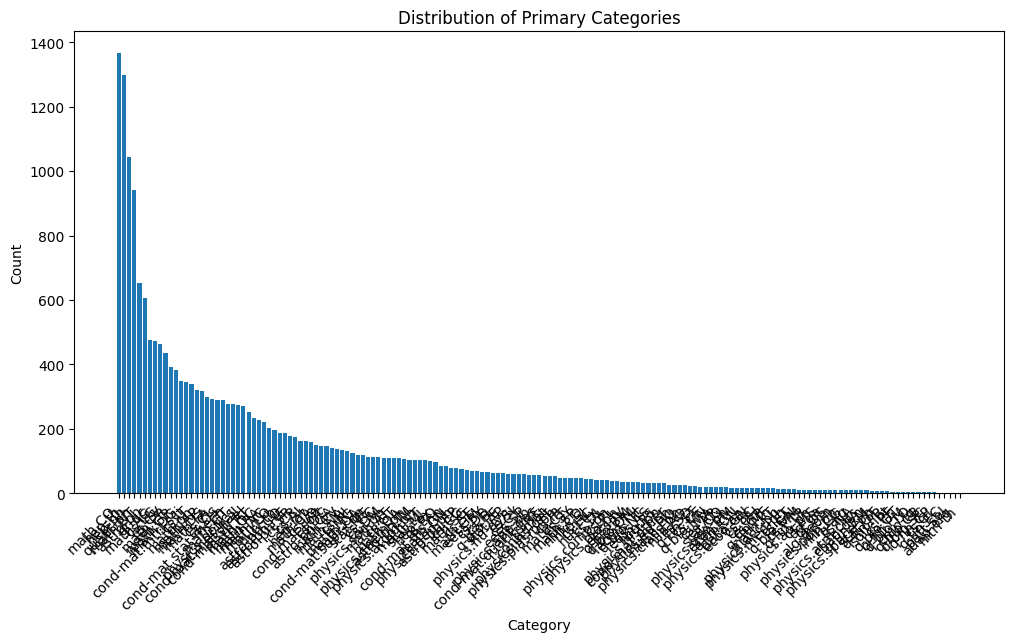

In [11]:
import matplotlib.pyplot as plt
cats = df.primary_category.value_counts()
plt.figure(figsize=(12, 6))
plt.bar(cats.index, cats.values)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Primary Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [12]:
len(df.authors.unique())

19987

In [13]:
authors = df.authors.unique()
authors

array(['Lucas H. R. de Souza', 'Zhujun Zhang',
       'Taher I. Mayassi; Mohamad N. Nasser', ...,
       'Garance Gourdel; Anne Driemel; Pierre Peterlongo; Tatiana Starikovskaya',
       'Alexandre Lambert; Manolo Dulva Hina; Celine Barth; Assia Soukane; Amar Ramdane-Cherif',
       'Louis Vaslin; Samuel Calvet; Vincent Barra; Julien Donini'],
      shape=(19987,), dtype=object)

In [14]:
test = 'Taher I. Mayassi; Mohamad N. Nasser'
first = list(test.partition(';'))
out = []
for i in range(0, len(first), 2):
    out.append(first[i])

print(out)

def list_authors(str_authors):
    l = list(str_authors.partition(';'))
    out = []
    for i in range(0, len(l), 2):
        out.append(l[i])
    
    return out
print(list_authors('T. C. Fujita; M. Uchida; Y. Kozuka; W. Sano; A. Tsukazaki; T. Arima; M. Kawasaki'))

['Taher I. Mayassi', ' Mohamad N. Nasser']
['T. C. Fujita', ' M. Uchida; Y. Kozuka; W. Sano; A. Tsukazaki; T. Arima; M. Kawasaki']


In [15]:
import numpy as np 

test = 'T. C. Fujita; M. Uchida; Y. Kozuka; W. Sano; A. Tsukazaki; T. Arima; M. Kawasaki'

def auth_str_to_list(auth_str):
    copy = auth_str
    still_separable = True
    out = []
    while still_separable:
        idx = copy.find(';')
        if idx == -1:
            out.append(copy.strip())
            still_separable = False
        else:
            out.append(copy[:idx].strip())
            copy = copy[idx+1:]

    return out

auth_str_to_list(test)


['T. C. Fujita',
 'M. Uchida',
 'Y. Kozuka',
 'W. Sano',
 'A. Tsukazaki',
 'T. Arima',
 'M. Kawasaki']

In [16]:
unique_authors = []
for auth in authors:
    l_authors = auth_str_to_list(auth)
    for author in l_authors:
        unique_authors.append(author)

print(len(unique_authors))

56111


In [17]:

network = {author:[] for author in unique_authors}
for i in range(len(df)):
    paper_authors = df.iloc[i].authors
    authors_list = auth_str_to_list(paper_authors)
    nbr_authors = len(authors_list)
    if nbr_authors > 1:
        for j in range(nbr_authors):
            for k in range(nbr_authors):
                if j != k and not (authors_list[k] in network[authors_list[j]]):
                    network[authors_list[j]] += [authors_list[k]]



In [19]:

for i in range(0,20):
    print(network[unique_authors[i]])
    

[]
[]
['Mohamad N. Nasser']
['Taher I. Mayassi']
[]
['M. Uchida', 'Y. Kozuka', 'W. Sano', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki', 'S. Ogawa']
['T. C. Fujita', 'Y. Kozuka', 'W. Sano', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki', 'S. Ogawa']
['T. C. Fujita', 'M. Uchida', 'W. Sano', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki', 'S. Ogawa']
['T. C. Fujita', 'M. Uchida', 'Y. Kozuka', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki']
['T. C. Fujita', 'M. Uchida', 'Y. Kozuka', 'W. Sano', 'T. Arima', 'M. Kawasaki', 'S. Ogawa', 'K. Ueda', 'J. Fujioka', 'B. -J. Yang', 'J. Shiogai', 'S. Nakamura', 'S. Awaji', 'N. Nagaosa', 'Y. Tokura']
['T. C. Fujita', 'M. Uchida', 'Y. Kozuka', 'W. Sano', 'A. Tsukazaki', 'M. Kawasaki', 'S. Ogawa', 'J. Yamaura', 'K. Ohgushi', 'H. Ohsumi', 'T. Hasegawa', 'I. Yamauchi', 'K. Sugimoto', 'S. Takeshita', 'A. Tokuda', 'M. Takata', 'M. Udagawa', 'M. Takigawa', 'H. Harima', 'Z. Hiroi']
['T. C. Fujita', 'M. Uchida', 'Y. Kozuka', 'W. Sano', 'A. Tsukazaki', 'T. Arima', 'S. Ogawa']
['B

In [ ]:
test_df = pd.read_csv("scraper/extractions/CSV/arxiv_data_1741086269.448.csv")

test_df.head()

ValueError: DataFrame constructor not properly called!

In [4]:
subcats = {
    "cond-mat": [
        "cond-mat.dis-nn",
        "cond-mat.mtrl-sci",
        "cond-mat.mes-hall",
        "cond-mat.other",
        "cond-mat.quant-gas",
        "cond-mat.soft",
        "cond-mat.stat-mech",
        "cond-mat.str-el",
        "cond-mat.supr-con",
    ],
    "hep-th": [],
    "hep-ex": [],
    "hep-ph": [],
    "gr-qc": [],
    "quant-ph": [],
    "q-fin": [
        "q-fin.CP",
        "q-fin.EC",
        "q-fin.GN",
        "q-fin.MF",
        "q-fin.PM",
        "q-fin.PR",
        "q-fin.RM",
        "q-fin.ST",
        "q-fin.TR",
    ],
    "nucl-ex": [],
    "CoRR": [],
    "nlin": [
        "nlin.AO",
        "nlin.CG",
        "nlin.CD",
        "nlin.SI",
        "nlin.PS",
    ],
    "physics": [
        "physics.acc-ph",
        "physics.app-ph",
        "physics.ao-ph",
        "physics.atom-ph",
        "physics.atm-clus",
        "physics.bio-ph",
        "physics.chem-ph",
        "physics.class-ph",
        "physics.comp-ph",
        "physics.data-an",
        "physics.flu-dyn",
        "physics.gen-ph",
        "physics.geo-ph",
        "physics.hist-ph",
        "physics.ins-det",
        "physics.med-ph",
        "physics.optics",
        "physics.ed-ph",
        "physics.soc-ph",
        "physics.plasm-ph",
        "physics.pop-ph",
        "physics.space-ph",
    ],
    "math-ph": [],
    "math": [
        "math.AG",
        "math.AT",
        "math.AP",
        "math.CT",
        "math.CA",
        "math.CO",
        "math.AC",
        "math.CV",
        "math.DG",
        "math.DS",
        "math.FA",
        "math.GM",
        "math.GN",
        "math.GT",
        "math.GR",
        "math.HO",
        "math.IT",
        "math.KT",
        "math.LO",
        "math.MP",
        "math.MG",
        "math.NT",
        "math.NA",
        "math.OA",
        "math.OC",
        "math.PR",
        "math.QA",
        "math.RT",
        "math.RA",
        "math.SP",
        "math.ST",
        "math.SG",
    ],
    "q-bio": [
        "q-bio.BM",
        "q-bio.CB",
        "q-bio.GN",
        "q-bio.MN",
        "q-bio.NC",
        "q-bio.OT",
        "q-bio.PE",
        "q-bio.QM",
        "q-bio.SC",
        "q-bio.TO",
    ],
    "nucl-th": [],
    "stat": [
        "stat.AP",
        "stat.CO",
        "stat.ML",
        "stat.ME",
        "stat.OT",
        "stat.TH",
    ],
    "hep-lat": [],
    "astro-ph": [
        "astro-ph.GA",
        "astro-ph.CO",
        "astro-ph.EP",
        "astro-ph.HE",
        "astro-ph.IM",
        "astro-ph.SR",
    ],
    "cs": [
        "cs.AI",
        "cs.AR",
        "cs.CC",
        "cs.CE",
        "cs.CG",
        "cs.CL",
        "cs.CR",
        "cs.CV",
        "cs.CY",
        "cs.DB",
        "cs.DC",
        "cs.DL",
        "cs.DM",
        "cs.DS",
        "cs.ET",
        "cs.FL",
        "cs.GL",
        "cs.GR",
        "cs.GT",
        "cs.HC",
        "cs.IR",
        "cs.IT",
        "cs.LG",
        "cs.LO",
        "cs.MA",
        "cs.MM",
        "cs.MS",
        "cs.NE",
        "cs.NI",
        "cs.OH",
        "cs.OS",
        "cs.PF",
        "cs.PL",
        "cs.RO",
        "cs.SC",
        "cs.SD",
        "cs.SE",
        "cs.SI",
    ],
    "econ": [
        "econ.EM",
        "econ.GN",
        "econ.TH",
    ],
    "eess": [
        "eess.AS",
        "eess.IV",
        "eess.SP",
        "eess.SY",
    ],
}

# Count subcategories for each main category
subcat_counts = {cat: len(subcats[cat]) for cat in subcats}

# Print results
final = 0
for cat, count in subcat_counts.items():
    final += count
    print(f"{cat}: {count} subcategories")
print(f'total {final}')
144*20000

cond-mat: 9 subcategories
hep-th: 0 subcategories
hep-ex: 0 subcategories
hep-ph: 0 subcategories
gr-qc: 0 subcategories
quant-ph: 0 subcategories
q-fin: 9 subcategories
nucl-ex: 0 subcategories
CoRR: 0 subcategories
nlin: 5 subcategories
physics: 22 subcategories
math-ph: 0 subcategories
math: 32 subcategories
q-bio: 10 subcategories
nucl-th: 0 subcategories
stat: 6 subcategories
hep-lat: 0 subcategories
astro-ph: 6 subcategories
cs: 38 subcategories
econ: 3 subcategories
eess: 4 subcategories
total 144


2880000